In [1]:
#import multiprocessing
import LibAu as la
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import h5py as h5
import warnings
warnings.filterwarnings('ignore')

In [2]:
km2kpc=3.24078e-17
def AngMom(dat):#rxv
    #print(dat.shape)
    dat[:,3]=dat[:,3]*km2kpc
    dat[:,4]=dat[:,4]*km2kpc
    dat[:,5]=dat[:,5]*km2kpc
    rxv = np.cross(dat[:,:3],dat[:,3:6])* dat[:,6].reshape((dat[:,6].size,1))
    #Li = (dat[:,1]*dat[:,5] - dat[:,2]*dat[:,4]) * dat[:,6]
    #Lj = (dat[:,2]*dat[:,3] - dat[:,0]*dat[:,5]) * dat[:,6]
    #Lk = (dat[:,0]*dat[:,4] - dat[:,1]*dat[:,3]) * dat[:,6]
    #Lx,Ly,Lz = np.sum(Li),np.sum(Lj),np.sum(Lk)
    return np.sum(rxv,axis=0)#np.array([Lx,Ly,Lz])

In [3]:
la.L3MHDsam

[16, 21, 23, 24, 27, 6]

Au-16
/virgo/simulations/Auriga/level3_MHD/halo_16/output/
DM particles:  30330070 30334251
Lambda_stars:  -0.009	0.006	0.167
Lambda_gas:  -0.091	0.088	0.564
Lambda_dm:  -0.026	0.039	0.052


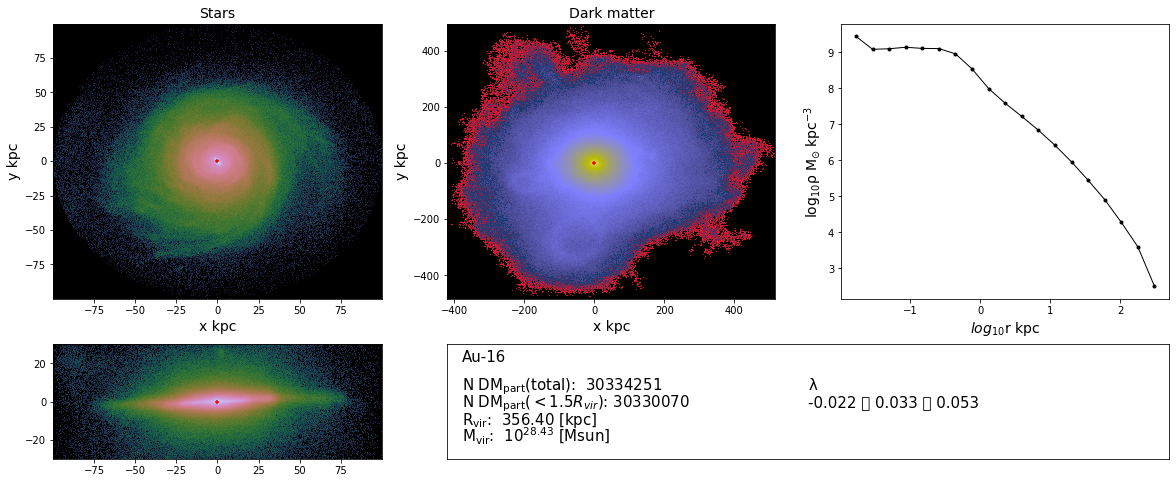

Au-21
/virgo/simulations/Auriga/level3_MHD/halo_21/output/
DM particles:  30957677 31503466
Lambda_stars:  0.018	-0.000	0.107
Lambda_gas:  0.266	0.064	0.287
Lambda_dm:  0.030	0.012	0.039


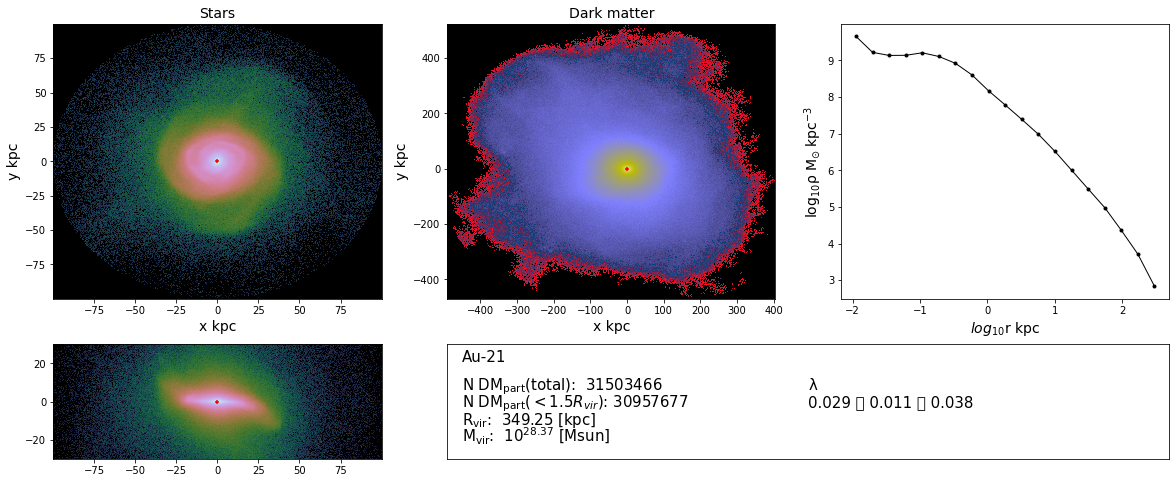

Au-23
/virgo/simulations/Auriga/level3_MHD/halo_23/output/
DM particles:  31586711 31618420
Lambda_stars:  0.001	-0.002	0.126
Lambda_gas:  -0.016	-0.006	0.328
Lambda_dm:  0.000	-0.002	0.028


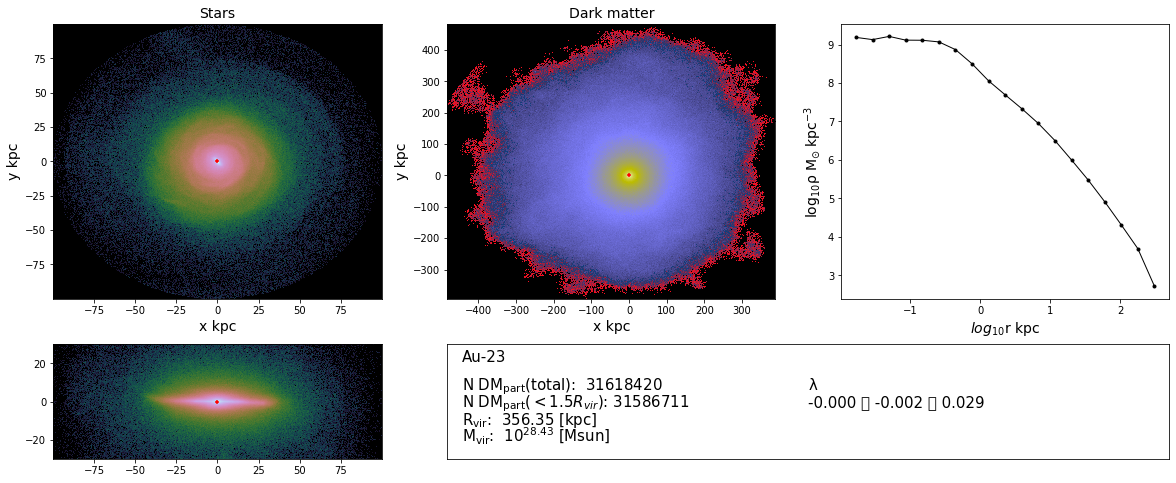

Au-24
/virgo/simulations/Auriga/level3_MHD/halo_24/output/
DM particles:  33555427 35153394
Lambda_stars:  0.000	-0.003	0.115
Lambda_gas:  -0.061	0.020	0.435
Lambda_dm:  -0.009	-0.008	0.021


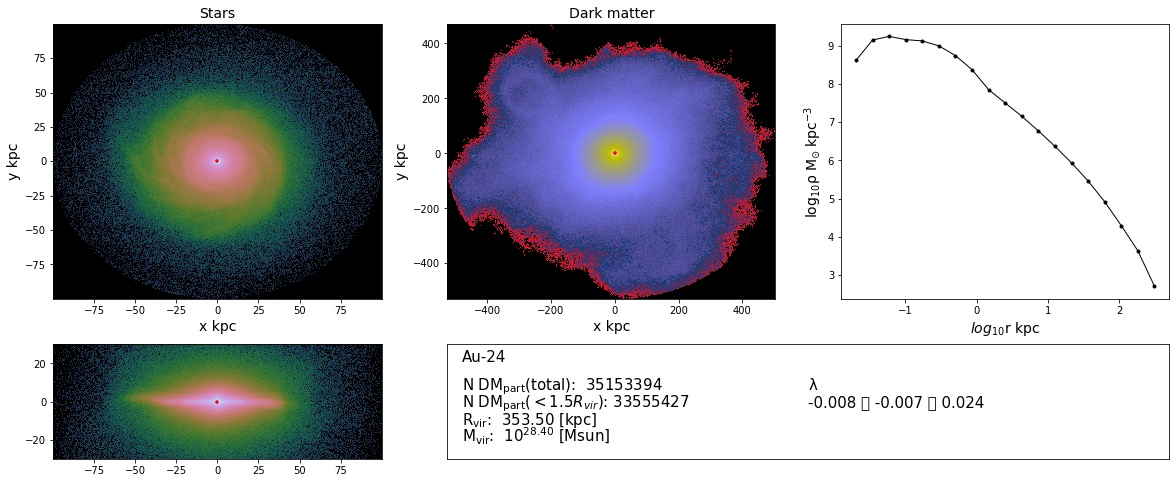

Au-27
/virgo/simulations/Auriga/level3_MHD/halo_27/output/
DM particles:  38721010 39056435
Lambda_stars:  -0.000	-0.009	0.077
Lambda_gas:  -0.004	-0.076	0.236
Lambda_dm:  0.003	0.004	0.023


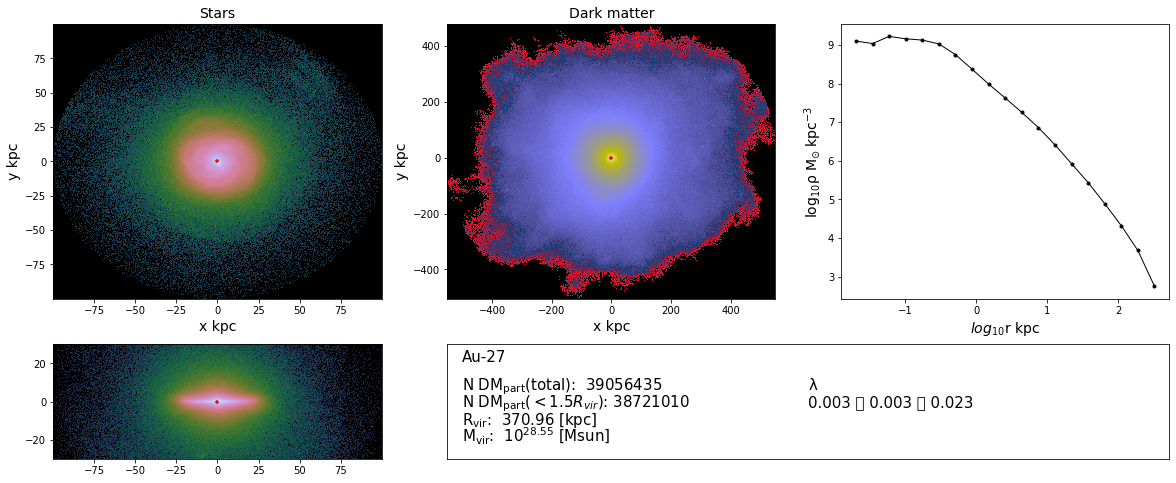

Au-6
/virgo/simulations/Auriga/level3_MHD/halo_6/output/
DM particles:  24161490 24184814
Lambda_stars:  -0.006	-0.005	0.079
Lambda_gas:  -0.115	-0.002	0.615
Lambda_dm:  -0.003	-0.012	0.034


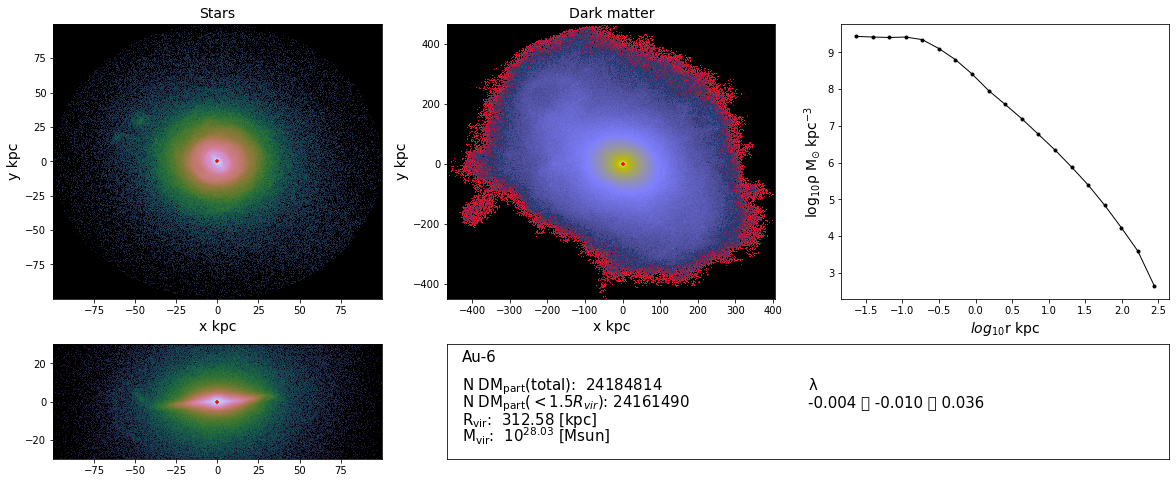

In [5]:
for nhalo in la.L3MHDsam:
    
    print('Au-%s'%nhalo)
    nsnap= 63
    sim = la.Reader_Au(Nhalo=nhalo,Nsnap=nsnap)
    print(sim.base)
    
    header = sim.Header()
    h=header['hubbleparam']
    sc=header['time']
    
    Rvir =sim.sf.data['frc2'][0]*1000*sc/h #[kpc] 
    Mvir =sim.sf.data['fmc2'][0]*1e10/h    #[Msun]
    
    #def func1(st,f): return sim.Snapshot_Subhalo(idSubhalo=0,snapType=st,fields=f)
    fields_stars = ['pos','vel','id','mass','type','pot','age']
    fields_dm = ['pos','vel','id','mass','type','pot']
    fields_gas = ['pos','vel','id','mass','type','pot']
    #manager = multiprocessing.Manager()
    #return_dict = manager.dict()
    
    #p1 = multiprocessing.Process(target=func1, args=('stars',fields_stars))
    #p2 = multiprocessing.Process(target=func1, args=('dm1',fields_dm))
    #p1.start()
    #p2.start()
    #p1.join()
    #p2.join()
    Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars)
    DatDM = sim.Snapshot_Subhalo(idSubhalo=0,snapType='dm1',fields=fields_dm)
    Datgas = sim.Snapshot_Subhalo(idSubhalo=0,snapType='gas',fields=fields_gas)
    #print(return_dict.values())
    #break
    #del p1,p2
    
    Data = {'stars':Datstars,'dm1':DatDM,'gas':Datgas}
    param = {'spos':sim.sf.data['spos'][0,:],
            'svel':sim.sf.data['svel'][0,:],
            'header':sim.Header()}
    
    gal = la.ToolRot(Data=Data, param=param)
    Data = gal.Rotate()
    Datstars=Data['stars']
    DatDM = Data['dm1']
    Datgas = Data['gas']
    
    
    # Stellar Parameter -------------------------------
    poss = Datstars['pos']#[kpc]
    Xs = poss[:,0] 
    Ys = poss[:,1]
    Zs = poss[:,2]
    Ms = Datstars['mass'] #[Msun]
    
    rs = np.sqrt(Xs**2 + Ys**2)
    rstar = np.sqrt(Xs**2 + Ys**2 +Zs**2)
    
    # DM paramater ------------------------------------
    posdm = DatDM['pos'] #[kpc
    Xdm = posdm[:,0]
    Ydm = posdm[:,1]
    Zdm = posdm[:,2]
    Mdm = DatDM['mass'] #[Msun]
    r3dm = np.sqrt(Xdm**2 + Ydm**2 + Zdm**2)
    rdm= np.sqrt(Xdm**2 + Ydm**2 + Zdm**2)
    Npartbe = len(r3dm)
    # --------------------------------------------------
    
    cuts= (rs<=100)& (np.abs(Zs)<=30)
    Xs,Ys,Zs,Ms=Xs[cuts],Ys[cuts],Zs[cuts],Ms[cuts]
    
    cutdm= r3dm<=1.5*Rvir
    Xdm,Ydm,Zdm,Mdm,r3dm=Xdm[cutdm],Ydm[cutdm],Zdm[cutdm],Mdm[cutdm],r3dm[cutdm]
    print('DM particles: ',len(r3dm),Npartbe)
    #------------------------------------------------------------------------
    #Compute Lambda
    G= 6.674*1e-11 #m3⋅kg−1⋅s−2
    m2kpc, kg2Msun = 3.2408*1e-20,5e-31
    G=G*(m2kpc**3) /kg2Msun # kpc3 Msun-1 s-2
    
    rgas = np.sqrt(Datgas['pos'][:,0]**2 + Datgas['pos'][:,1]**2 + Datgas['pos'][:,2]**2)
    r200 = Rvir
    sels,selg,seld = (rstar<=r200) , (rgas<=r200) , (rdm<=r200)
    Mencs,Mencg,Mencd=np.sum(Datstars['mass'][sels]), np.sum(Datgas['mass'][selg]), np.sum(DatDM['mass'][seld])
    Menc =  Mencs+Mencg+Mencd
    #print(mass200encl,m200)
    #r X v
    Jstar = AngMom(np.hstack((Datstars['pos'],Datstars['vel'],Datstars['mass'].reshape(Datstars['mass'].size,1)))[sels])
    Jgas  = AngMom(np.hstack((Datgas['pos'],Datgas['vel'],Datgas['mass'].reshape(Datgas['mass'].size,1)))[selg])
    Jdm   = AngMom(np.hstack((DatDM['pos'],DatDM['vel'],DatDM['mass'].reshape(DatDM['mass'].size,1)))[seld])
    ## revisar calculo de J para dm

    J = Jstar+Jgas+Jdm

    #print(Jstar,Jgas,Jdm,J)
    V200 = np.sqrt((G*Menc)/r200)
    V200s,V200g,V200d = np.sqrt((G*Mencs)/r200),np.sqrt((G*Mencg)/r200),np.sqrt((G*Mencd)/r200)
    Lambda = J / (np.sqrt(2)*Menc*r200*V200)
    Ls = Jstar / (np.sqrt(2)*Mencs*r200*V200s)
    Lg = Jgas / (np.sqrt(2)*Mencg*r200*V200g)
    Ld = Jdm / (np.sqrt(2)*Mencd*r200*V200d)
    
    print('Lambda_stars:  %.3f\t%.3f\t%.3f'%(Ls[0],Ls[1],Ls[2]))
    print('Lambda_gas:  %.3f\t%.3f\t%.3f'%(Lg[0],Lg[1],Lg[2]))
    print('Lambda_dm:  %.3f\t%.3f\t%.3f'%(Ld[0],Ld[1],Ld[2]))
    #------------------------------------------------------------------------
    Hsf,_xsf,_ysf,boxsf = la.StellarDensity2D(Xs,Ys,Ms,npix = [720,720],style='SD')
    Hse,_xse,_yse,boxse = la.StellarDensity2D(Xs,Zs,Ms,npix = [720,int(720/2)],style='SD')

    Hdm,_xdm,_ydm,boxdm = la.StellarDensity2D(Xdm,Ydm,Mdm,npix = [720,720],style='SD')
    
    


    plt.figure(figsize=(20,8))
    
    ax1=plt.subplot(3,3,(1,4))
    ax1.patch.set_facecolor('black')
    extentsf = _xsf.min(),_xsf.max(),_ysf.min(),_ysf.max()
    plt.imshow(np.log10(Hsf).T,cmap='cubehelix',extent=extentsf,aspect='auto',origin='lower',interpolation='none')
    plt.scatter(0,0,s=20,c='r',marker='+')
    #plt.title('Au-%s'%nhalo,fontsize=14)
    plt.title('Stars',fontsize=14)
    plt.xlabel('x kpc',fontsize=14)
    plt.ylabel('y kpc',fontsize=14)
    
    ax2=plt.subplot(3,3,7)
    ax2.patch.set_facecolor('black')
    extentse = _xse.min(),_xse.max(),_yse.min(),_yse.max()
    plt.imshow(np.log10(Hse).T,cmap='cubehelix',extent=extentse,aspect='auto',origin='lower',interpolation='none')
    plt.scatter(0,0,s=20,c='r',marker='+')

    ax3=plt.subplot(3,3,(2,5))
    ax3.patch.set_facecolor('black')
    extentdm = _xdm.min(),_xdm.max(),_ydm.min(),_ydm.max()
    plt.imshow(np.log10(Hdm).T,cmap='gist_stern',extent=extentdm,aspect='auto',origin='lower',interpolation='none')
    plt.scatter(0,0,s=10,c='r',marker='+')
    plt.title('Dark matter',fontsize=14)
    plt.xlabel('x kpc',fontsize=14)
    plt.ylabel('y kpc',fontsize=14)
    
    plt.subplot(3,3,(3,6))
    r3min,r3max=np.log10(r3dm).min(),np.log10(r3dm).max()
    r3dml = np.log10(r3dm)
    DR = np.linspace(r3min,r3max,20)
    DRn = 10**DR
    rho = []
    for i,j in enumerate(DR):
        if i==len(DR)-1:continue
        sel = (j<=r3dml)&(r3dml<DR[i+1])
        vol = (4/3)*np.pi*(DRn[i+1]**3 - DRn[i]**3)
        rho.append(np.sum(Mdm[sel])/vol)

    plt.plot(DR[:-1],np.log10(rho),lw=1,marker='.',c='k')
    plt.ylabel(r'$\rm log_{10} \rho\; M_{\odot}\;kpc^{-3}}$',fontsize=14)
    plt.xlabel(r'$log_{10}$r kpc',fontsize=14)
    #print(DR,rho)
    
    plt.subplot(3,3,(8,9))

    plt.text(0.02,0.85,'Au-%s'%nhalo,fontsize=15)
    plt.text(0.02,0.6,r'N $\rm DM_{part}$(total):  %s'%Npartbe,fontsize=15)
    plt.text(0.02,0.45,r'N $\rm DM_{part}$($<1.5R_{vir}$): %s'%len(r3dm),fontsize=15)
    plt.text(0.02,0.3,r'$\rm R_{vir}$:  %.2f [kpc]'%Rvir,fontsize=15)
    plt.text(0.02,0.15,r'$\rm M_{vir}$:  $10^{%.2f}$ [Msun]'%np.log(Mvir),fontsize=15)
    plt.text(0.5,0.6,r'$\rm \lambda$',fontsize=15)
    plt.text(0.5,0.45,'%.3f \t %.3f \t %.3f'%(Lambda[0],Lambda[1],Lambda[2]),fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(hspace=0.4)
    plt.savefig('plots/profiles_Au%s.pdf'%nhalo)
    plt.show()
    plt.close()
    '''
    #g1 = hf.create_group('Au-%s'%nhalo)
    hf = h5.File('Table/Data_DM_Au-%s.hdf5'%nhalo,'w')
    hf.create_dataset('x'    ,data=Xdm)
    hf.create_dataset('y'    ,data=Ydm)
    hf.create_dataset('z'    ,data=Zdm)
    hf.create_dataset('m'    ,data=Mdm)
    
    hf.close()'''

    

In [ ]:
print('%s \t %s'%(Lambda[0],Lambda[1]))

In [ ]:
ls /virgo/simulations/Auriga/level3_MHD/

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(3,3,(1,4))

plt.subplot(3,3,7)

plt.subplot(3,3,(2,5))

plt.subplot(3,3,(3,6))

plt.subplot(3,3,(8,9))

plt.text(0.02,0.85,'Au-N',fontsize=15)
plt.text(0.02,0.6,r'N $\rm DM_{part}$(total):  %s'%12345,fontsize=15)
plt.text(0.02,0.45,r'N $\rm DM_{part}$($<1.5R_{vir}$): %s'%12345,fontsize=15)
plt.text(0.02,0.3,r'$\rm R_{vir}$:  %.2f [kpc]'%12.512345,fontsize=15)
plt.text(0.02,0.15,r'$\rm M_{vir}$:  $10^{%s}$ [Msun]'%10,fontsize=15)
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(hspace=0.4)
plt.show()
plt.close()